In [7]:
import yaml

# Path to your YAML file
input_file_path = "outputs/2025-06-06/cedar_gemini_clean_entity_type_map.yaml"

# Load the YAML content
with open(input_file_path, "r") as file:
    loaded_data = yaml.safe_load(file)

# Now `loaded_data` is a Python dictionary
print(loaded_data.keys())  # For example, show the top-level URLs

dict_keys(['https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002', 'https://lpdaac.usgs.gov/products/mod09a1v061/', 'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en', 'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en', 'https://zenodo.org/records/8319440', 'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz', 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e', 'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7', 'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e', 'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5', 'https://zenodo.org/records/11440456', 'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json', 'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g', 'https://datahuiswadden.openearth.nl/

In [15]:
list(loaded_data.keys())[11]

'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json'

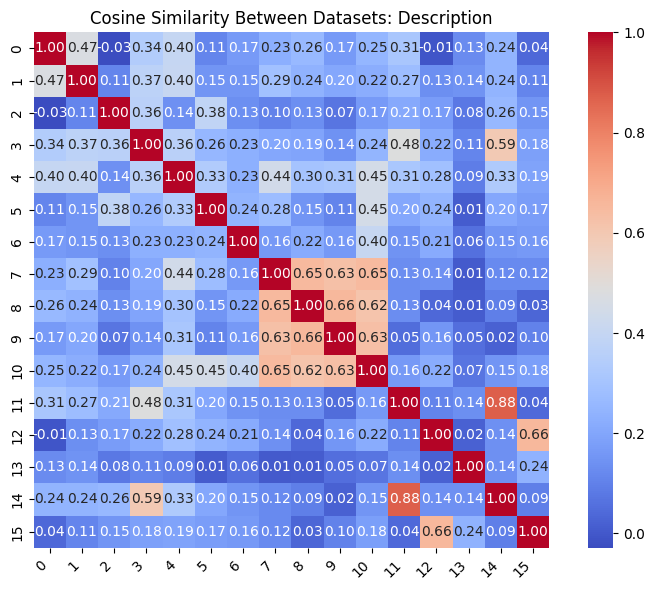

In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

concerned_attributes = ["Description"]
embedding_list = []
for attr in concerned_attributes:
    value_list = []
    for url, metadata_dict in loaded_data.items():
        if attr in metadata_dict:
            # Append the value of the concerned attribute to the list
            value_list.append(metadata_dict[attr][0])
        else:
            # If the attribute is not present, append a placeholder or default value
            random_text = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
            value_list.append(random_text)

    # Load a pretrained model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and effective

    # Encode texts to get embeddings
    embeddings = model.encode(value_list)
    embedding_list.append(embeddings)


concatenated = np.concatenate([embedding_list[0]], axis=1)
# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(concatenated)

concerned_attributes_string = "&".join(concerned_attributes)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cos_sim_matrix, annot=True, fmt=".2f", xticklabels=range(len(value_list)), yticklabels=range(len(value_list)), cmap="coolwarm", square=True)
plt.title("Cosine Similarity Between Datasets:" + " " + concerned_attributes_string)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Dataset 15:
  - Ecotopenkaart Waddenzee volgens de ZES.1 Typologie

Dataset 12:
  - Een ecotoop is een ecomorfologische, landschappelijke karteerbare eenheid..

----------------------
Dataset 3:
  - NDVI. NDVI quantifies vegetation greenness, computed from 30-m bi-monthly aggregated
    and gapfilled GLAD Landsat ARD from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

------------------
Dataset 11:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

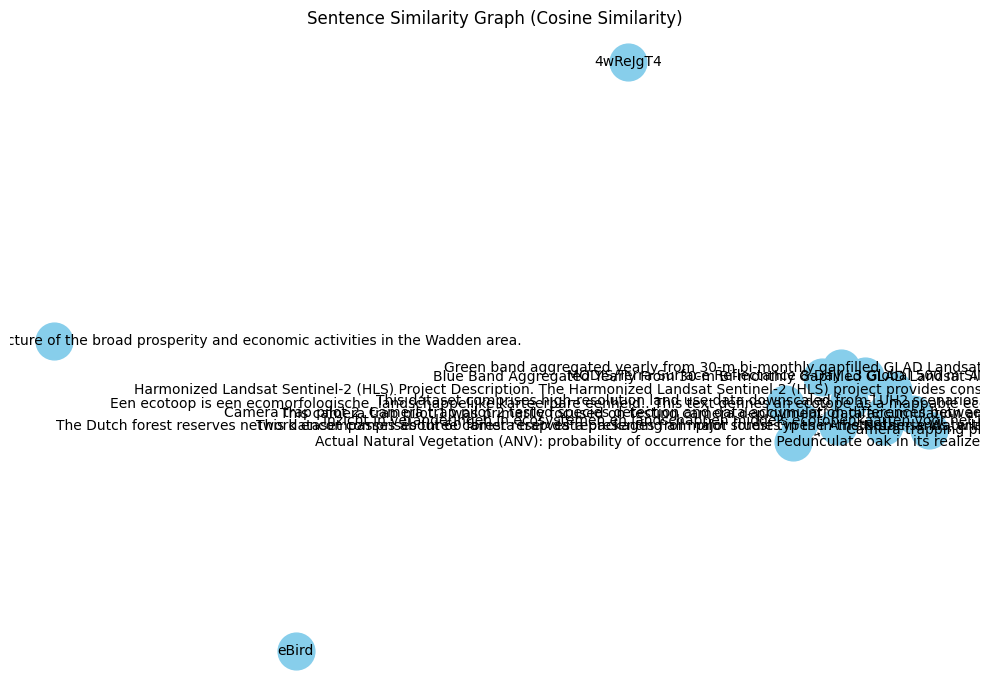

In [69]:
import networkx as nx

texts = value_list  # Use the list of values as texts for the graph

# Create graph
G = nx.Graph()

# Add nodes
for i, text in enumerate(texts):
    G.add_node(i, label=text)

# Add edges with weights (only if similarity > threshold to reduce clutter)
threshold = 0.3
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        weight = cos_sim_matrix[i, j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

# Compute layout — higher weights = stronger spring pull
# Invert similarity to distance: higher similarity = shorter distance
distances = {(i, j): 1 / cos_sim_matrix[i, j] for i, j in G.edges}
pos = nx.spring_layout(G, weight=None, k=None, scale=2, iterations=100, pos=None, fixed=None, center=None, dim=2)

# Draw nodes and edges
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*4 for u, v in G.edges], alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i: texts[i] for i in G.nodes}, font_size=10)

# Draw edge labels (similarity values)
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Sentence Similarity Graph (Cosine Similarity)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import numpy as np
import umap
# Dimensionality reduction to 2D
reduced = TSNE(n_components=2, metric='cosine', perplexity=5, random_state=42).fit_transform(embeddings)

# reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced = reducer.fit_transform(embeddings)

# Create scatter plot
fig = go.Figure()

# Add nodes
for i, (x, y) in enumerate(reduced):
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        text=[str(i)],
        textposition="top center",
        marker=dict(size=10),
        hoverinfo='text'
    ))

# Optionally: Add lines for high-similarity pairs
threshold = 0.5
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        if cos_sim_matrix[i][j] > threshold:
            fig.add_trace(go.Scatter(
                x=[reduced[i][0], reduced[j][0]],
                y=[reduced[i][1], reduced[j][1]],
                mode='lines',
                line=dict(width=cos_sim_matrix[i][j]*5, color='lightgray'),
                hoverinfo='skip'
            ))

fig.update_layout(
    title="Interactive 2D Sentence Similarity Graph (TSNE)",
    showlegend=False,
    margin=dict(l=20, r=20, t=40, b=20),
    xaxis=dict(scaleanchor='y', scaleratio=1),
    yaxis=dict(scaleanchor='x', scaleratio=1),
)
fig.show()


NameError: name 'embeddings' is not defined

(16, 384)